# Evaluation

In [1]:
%%capture
# Libraries for evaluation

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from scipy.stats import norm
from sdmetrics.visualization import get_column_pair_plot
from sdv.evaluation.single_table import evaluate_quality, run_diagnostic, get_column_plot, get_column_pair_plot
from sdv.metadata import SingleTableMetadata
from table_evaluator import TableEvaluator

In [2]:
%%capture

# Load logs of losses
logs_folder = './logs/'
model_log_file_path = input("Enter the losses log file name (without extension): ").lower()
loss_values_path = os.path.join(logs_folder, model_log_file_path + '.csv')
loss_values = pd.read_csv(loss_values_path)

# Create evaluation folder if it does not exist
evaluation_folder = 'evaluation'
os.makedirs(evaluation_folder, exist_ok=True)

# Load real data
input_folder = './input/'
input_file_name = input("Enter the input file name (without extension): ").lower()
real_data_path = os.path.join(input_folder, input_file_name + '.csv')
real_data = pd.read_csv(real_data_path)

# Load synthetic data
output_folder = './output/'
output_file_name = input("Enter the output file name (without extension): ").lower()
synthetic_data_path = os.path.join(output_folder, output_file_name + '.csv')
synthetic_data = pd.read_csv(synthetic_data_path)

In [ ]:
%%capture
# Copy for inputs

# ctgan_0.1 inputs
# -- losses: log_n5000_ep25000_20240403_205131
# -- input: medium_input
# -- output: synthetic_data_n5024_20240403_205131_ep25000_b32

# ctgan_0.2 inputs
# -- losses: loss_values_cs_ctgan_ep5000_i_filtered_new_data_14042024_181147
# -- input: filtered_new_data
# -- output: cs_synthetic_data_n50000_b32_m_cs_ctgan_e_30000_i_filtered_new_data_15042024_012706_15042024_085216

In [3]:
%%capture

# Rename columns
# Rename column 'Total.Backward.Packets' to 'Total.Bwd.Packets'
real_data = real_data.rename(columns={'Total.Backward.Packets': 'Total.Bwd.Packets'})
synthetic_data = synthetic_data.rename(columns={'Total.Backward.Packets': 'Total.Bwd.Packets'})

# Define metadata
metadata_dict = {
    "columns": {
        "Timestamp": {
            "sdtype": "datetime",
            "datetime_format": "%Y-%m-%d %H:%M:%S"
        },
        "Source.IP": {
            "sdtype": "categorical"
        },
        "Source.Port": {
            "sdtype": "categorical"
        },
        "Destination.IP": {
            "sdtype": "categorical"
        },
        "Destination.Port": {
            "sdtype": "categorical"
        },
        "Protocol": {
            "sdtype": "categorical"
        },
        "Flow.Duration": {
            "sdtype": "numerical"
        },
        "Total.Fwd.Packets": {
            "sdtype": "numerical"
        },
        "Total.Bwd.Packets": {
            "sdtype": "numerical"
        },
        "Total.Length.of.Fwd.Packets": {
            "sdtype": "numerical"
        },
        "Total.Length.of.Bwd.Packets": {
            "sdtype": "numerical"
        }
    },
    "METADATA_SPEC_VERSION": "SINGLE_TABLE_V1"
}
metadata = SingleTableMetadata.load_from_dict(metadata_dict)

## SDV Diagnostics

In [4]:
# SDV Diagnostic
diagnostic = run_diagnostic(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata
)

# Data quality
quality_report = evaluate_quality(
    real_data,
    synthetic_data,
    metadata
)

Generating report ...
(2/2) Evaluating Data Structure: : 100%|██████████| 1/1 [00:00<00:00, 141.37it/s]

Overall Score: 100.0%

Properties:
- Data Validity: 100.0%
- Data Structure: 100.0%
Generating report ...
(1/2) Evaluating Column Shapes: :   0%|          | 0/11 [00:00<?, ?it/s]

(2/2) Evaluating Column Pair Trends: : 100%|██████████| 55/55 [01:05<00:00,  1.19s/it]

Overall Score: 81.99%

Properties:
- Column Shapes: 83.75%
- Column Pair Trends: 80.24%


# Plotting the loss functions

Plot loss function of generator and discriminator

In [5]:
# Plot loss function of generator and discriminator
fig = go.Figure(data=[go.Scatter(x=loss_values['Epoch'], y=loss_values['Generator Loss'], name='Generator Loss'),
                      go.Scatter(x=loss_values['Epoch'], y=loss_values['Discriminator Loss'], name='Discriminator Loss')])


# Update the layout for best viewing
fig.update_layout(template='plotly_white',
                    legend_orientation="h",
                    legend=dict(x=0, y=1.1))

title = 'CTGAN loss function for dataset: '
fig.update_layout(title=title, xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

# Save plot 
plot_html_file_path = os.path.join(evaluation_folder, f'plot_{model_log_file_path}.html')
fig.write_html(plot_html_file_path)

### SDV Visualisation 

In [6]:
%%capture  
# not working in Jupyter
# Visualisation
fig = get_column_plot(
    real_data=real_data,
    synthetic_data=synthetic_data,
    metadata=metadata,
    column_name="Timestamp"
)
fig.show()

fig = get_column_pair_plot(
    metadata=metadata,
    real_data=real_data,
    synthetic_data=synthetic_data,
    column_names=['Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets'],
    plot_type='heatmap'
)

fig.show()

# Evaluation

In [7]:
%%capture

# Close cached plots
plt.close('all')
plt.clf()

### Exploratory data analysis

In [8]:
real_data.head(3)

,Timestamp,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Bwd.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets
0,2017-04-26 11:11:17,172.19.1.46,52422,10.200.7.7,3128,6,45523,22,55,132,110414.0
1,2017-04-26 11:11:17,10.200.7.7,3128,172.19.1.46,52422,6,1,2,0,12,0.0
2,2017-04-26 11:11:17,50.31.185.39,80,10.200.7.217,38848,6,1,3,0,674,0.0


In [9]:
synthetic_data.head(3)

,Timestamp,Source.IP,Source.Port,Destination.IP,Destination.Port,Protocol,Flow.Duration,Total.Fwd.Packets,Total.Bwd.Packets,Total.Length.of.Fwd.Packets,Total.Length.of.Bwd.Packets
0,2017-04-26 11:11:22,10.200.7.9,3128,192.168.10.130,54538,6,120374,2,3,2576,5995.0
1,2017-04-26 11:11:22,10.200.7.199,34014,52.50.122.110,443,6,749621,10,5,3468,46114.0
2,2017-04-26 11:11:17,10.200.7.196,49544,162.208.22.39,443,6,12421234,17,5,1800,636.0


In [10]:
# Display information about synthetic data
print("\nSynthetic_data:")
synthetic_data.info()


Synthetic_data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024 entries, 0 to 5023
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Timestamp                    5024 non-null   datetime64[ns]
 1   Source.IP                    5024 non-null   object        
 2   Source.Port                  5024 non-null   int64         
 3   Destination.IP               5024 non-null   object        
 4   Destination.Port             5024 non-null   int64         
 5   Protocol                     5024 non-null   int64         
 6   Flow.Duration                5024 non-null   int64         
 7   Total.Fwd.Packets            5024 non-null   int64         
 8   Total.Bwd.Packets            5024 non-null   int64         
 9   Total.Length.of.Fwd.Packets  5024 non-null   int64         
 10  Total.Length.of.Bwd.Packets  5024 non-null   float64       
dtypes: datetime64[ns](1), floa

### Statistical analyses

In [11]:
%%capture
# Preparing the correlation matrix

# Real data
# Select only numeric columns for correlation calculation
real_data_numeric = real_data.select_dtypes(include=['int', 'float']).columns.drop(['Protocol'])
real_data_numeric = sorted(real_data_numeric)

# Calculate real data correlation matrix
real_data_corr_matrix = real_data[real_data_numeric].corr()

# Fake data
# Select only numeric columns for correlation calculation
synthetic_data_numeric = synthetic_data.select_dtypes(include=['int', 'float']).columns.drop(['Protocol'])
synthetic_data_numeric = sorted(synthetic_data_numeric)

# Calculate correlation matrix for numeric columns
synthetic_data_corr_matrix = synthetic_data[synthetic_data_numeric].corr()

# Close all cached plots
plt.close('all')

# Note on NaNs in correlation matrix
# Standard deviation of a constant variable (only one value) is zero, which leads to division by zero in the correlation formula (e.g. for 'Protocol')

In [32]:
%%capture
# Preparation: define metadata
'''If we do not specify categorical columns when initialising the TableEvaluator,
   it will consider all columns with more than 50 unique values a continuous column 
   and anything with less a categorical columns.'''

cat_cols = ['Timestamp','Source.IP', 'Source.Port', 'Destination.IP', 'Destination.Port', 'Protocol']

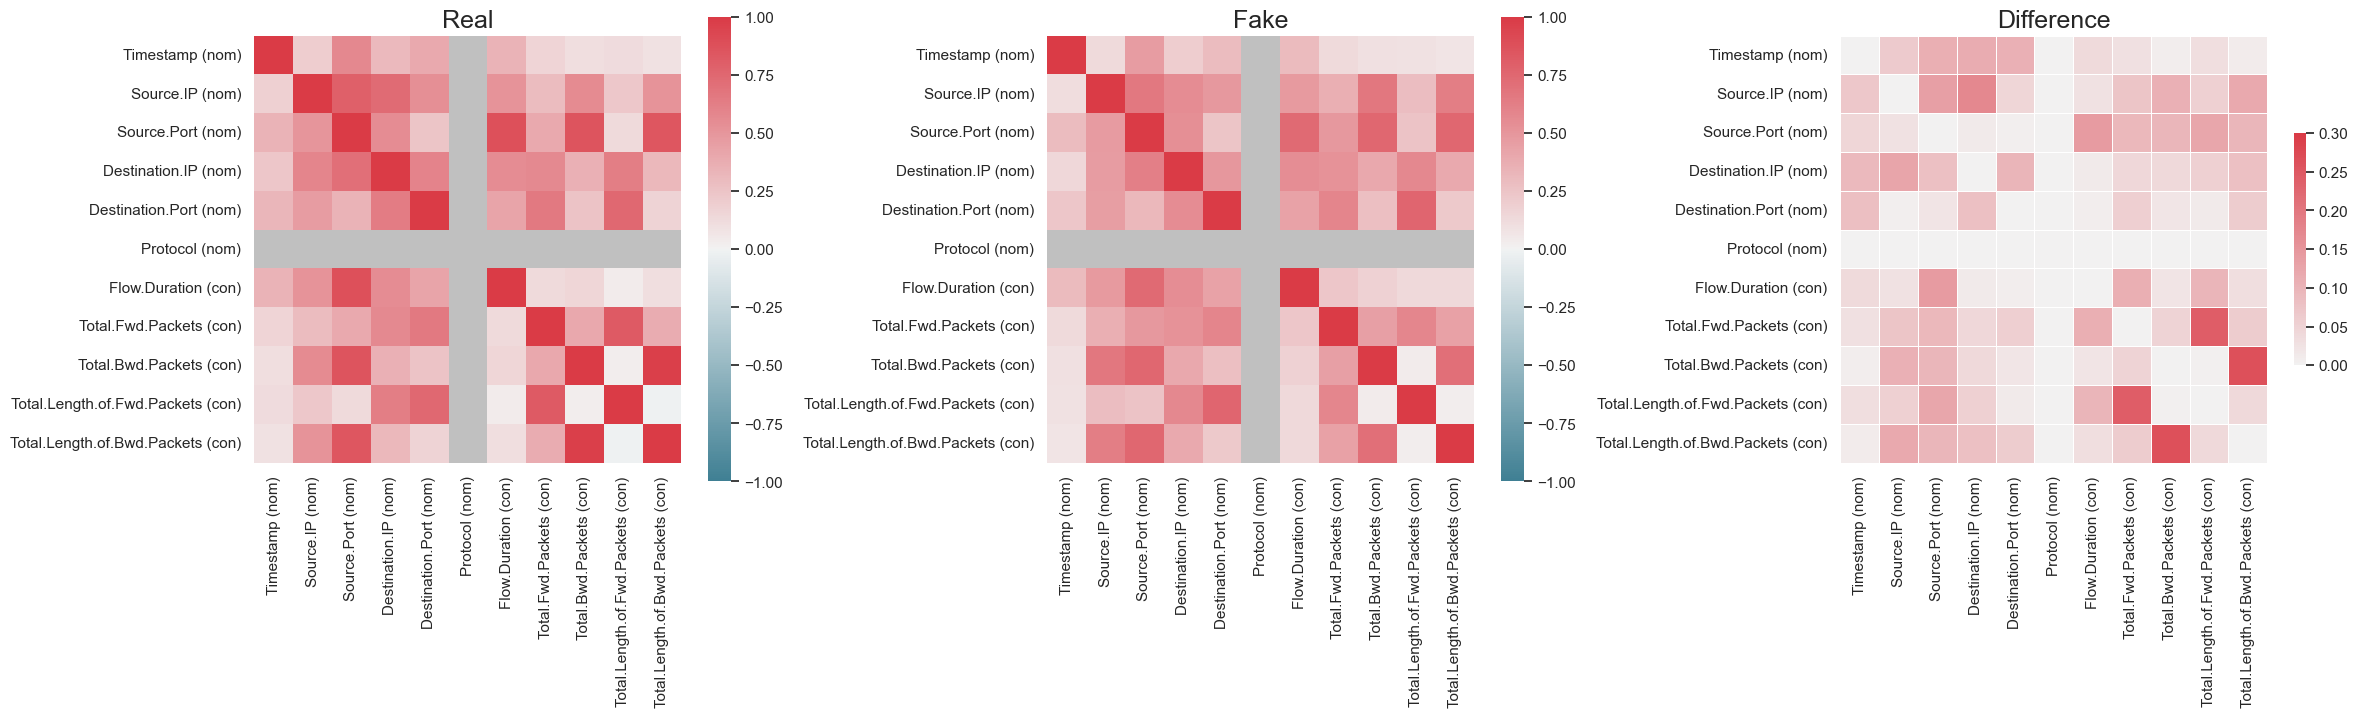

In [33]:
table_evaluator = TableEvaluator(real_data, synthetic_data)
evaluator = TableEvaluator(real_data, synthetic_data,  cat_cols=cat_cols)

evaluator.plot_correlation_difference()

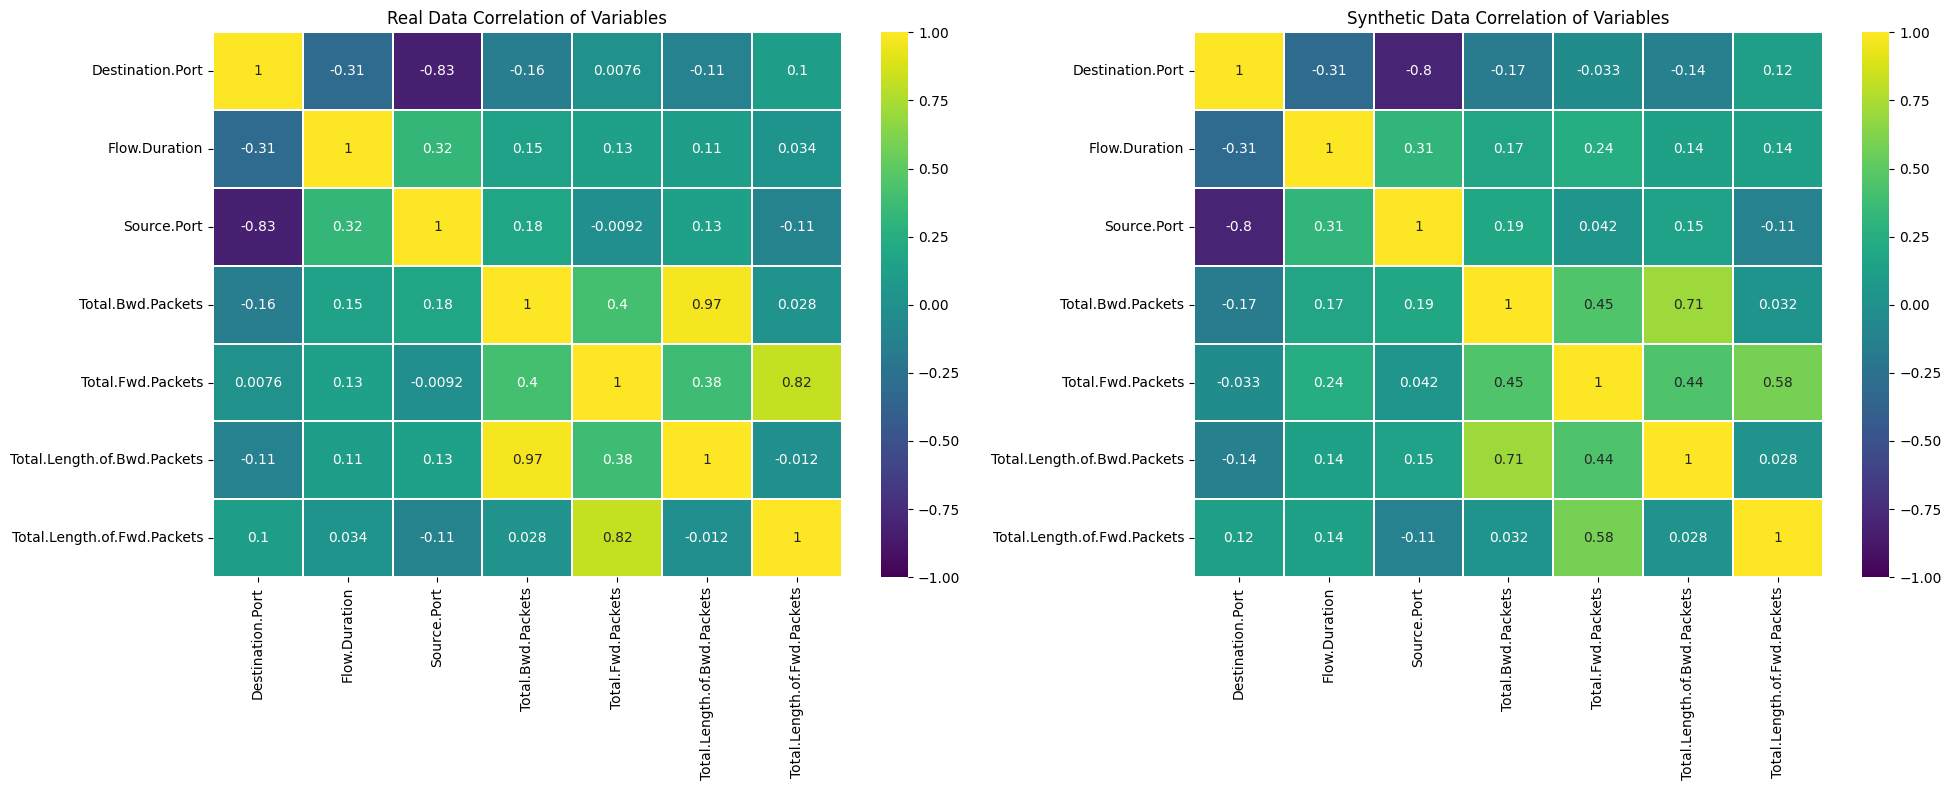

In [12]:
# Heatmap

# Set heatmap size
plt.figure(figsize=(20, 8))

# Plot correlation_matrix1
plt.subplot(1, 2, 1)
sns.heatmap(real_data_corr_matrix, vmax=1, vmin=-1, annot=True, linewidths=0.1, cmap='viridis')
plt.title('Real Data Correlation of Variables')

# Plot correlation_matrix0
plt.subplot(1, 2, 2)
sns.heatmap(synthetic_data_corr_matrix, vmax=1, vmin=-1, annot=True, linewidths=0.1, cmap='viridis')
plt.title('Synthetic Data Correlation of Variables')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

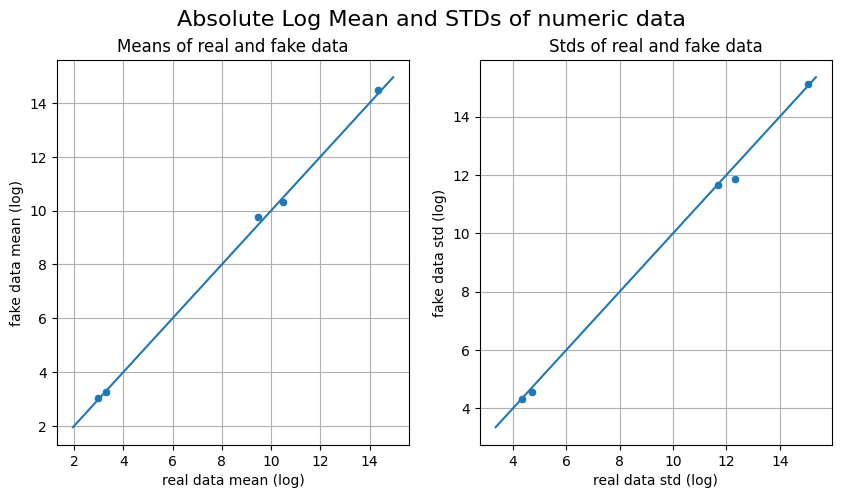

In [16]:
evaluator.plot_mean_std()

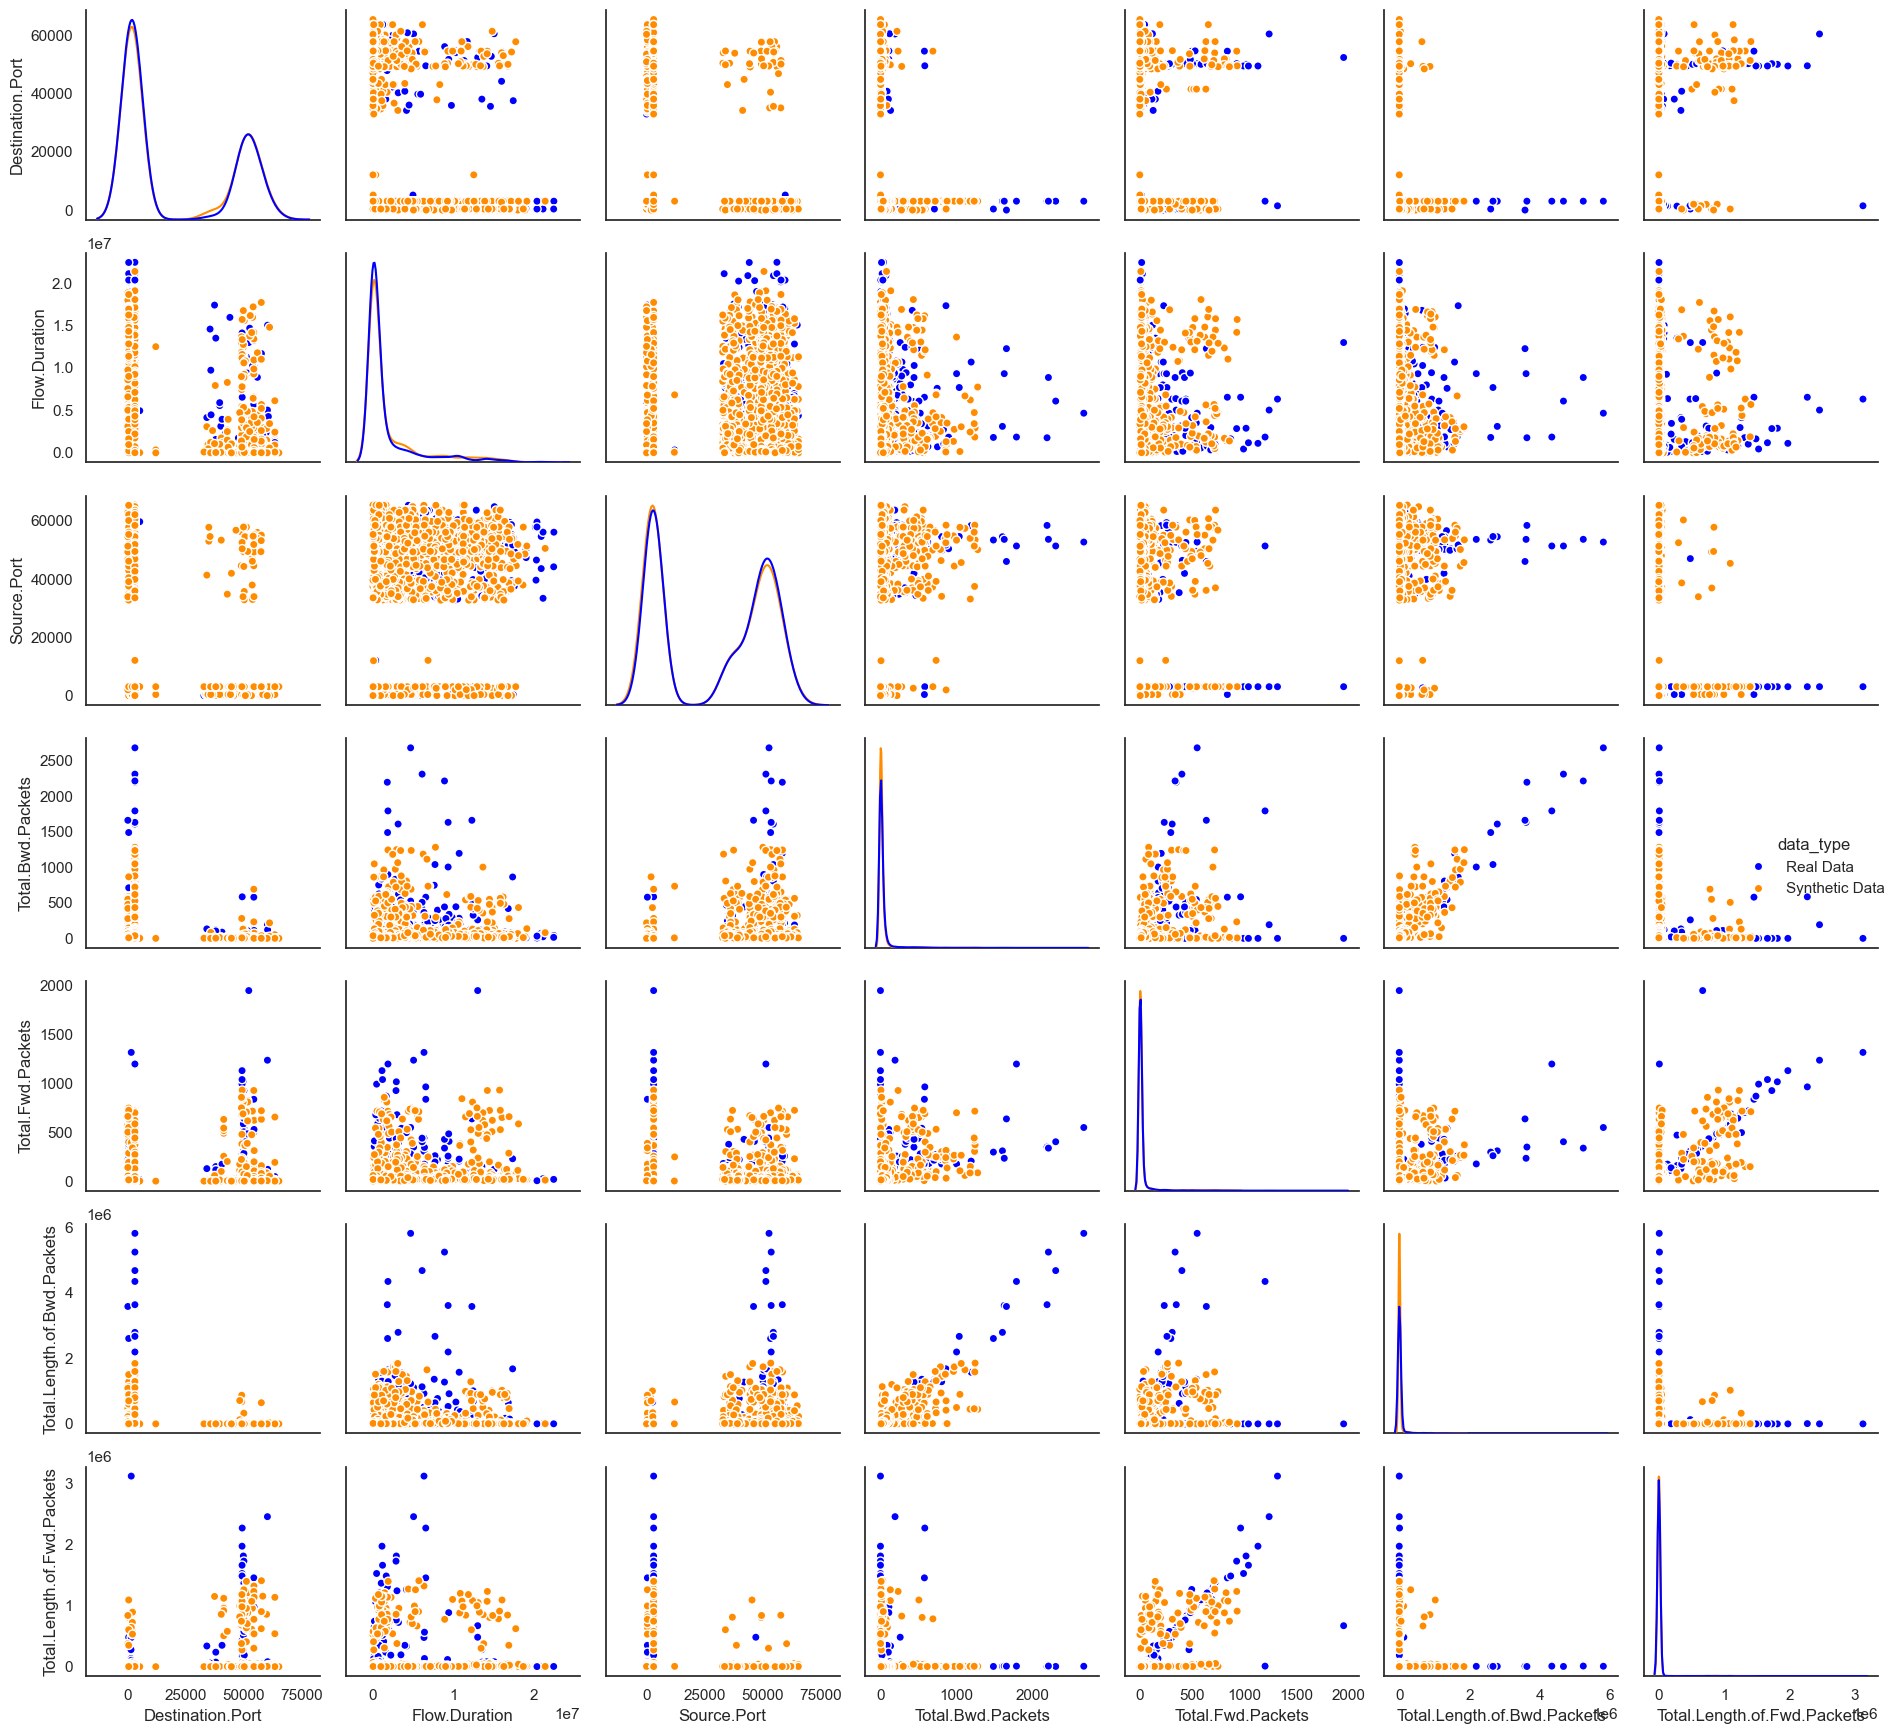

In [49]:
# Pairplot

# DataFrame with the selected numeric columns for real data
real_data_numeric_df = real_data[real_data_numeric]

# DataFrame with the selected numeric columns for synthetic data
synthetic_data_numeric_df = synthetic_data[synthetic_data_numeric]

# Colour datapoints for real and synthetic data points
palette = {"Real Data": "blue", "Synthetic Data": "darkorange"}

# Combine real and synthetic data into a single DataFrame for plotting
combined_data = pd.concat([real_data_numeric_df.assign(data_type="Real Data"), 
                           synthetic_data_numeric_df.assign(data_type="Synthetic Data")])

# Plot pairplot with different colors for real and synthetic data points
sns.pairplot(combined_data, hue="data_type", plot_kws=dict(markers='+', linewidth=1), palette=palette, diag_kws=dict(fill=False)) 
# plot_kws=dict(markers='+', linewidth=1)

# Adjust plot layout to prevent overlap of legend
plt.tight_layout()
plt.show()

### Appendix

**Table Evaluator**

" TableEvaluator is a library to evaluate how similar a synthesized dataset is to a real data. In other words, it tries to give an indication into how real your fake data is. With the rise of GANs, specifically designed for tabular data, many applications are becoming possibilities. "

Check the full documentation for [table evaluator](https://baukebrenninkmeijer.github.io/table-evaluator/) or the GitHub [repo](https://github.com/Baukebrenninkmeijer/table-evaluator/tree/master).

### Experiments

**Tests**
The following metrics are provided by an SDV employee in the GitHub [repo](https://github.com/sdv-dev/SDV/discussions/980#top).
                                                                           
KS complement: This metric measures whether the shape of a single column is similar in the real and synthetic data. Applied to numerical columns.
TV complement: This metric is similar to the KSComplement, except we can use it on categorical columns.
CorrelationSimilarity: This metric measures whether the synthetic data captures the pairwise correlations that are present in the real data.
CategoricalCoverage: This metric measures the coverage for categorical columns. This is important to verify that the CTGAN didn't experience any mode collapse.

In [ ]:
%%capture
# Imports
import itertools
from sdmetrics.column_pairs import CorrelationSimilarity
from sdmetrics.single_column import KSComplement, TVComplement, CategoryCoverage


In [ ]:
%%capture
# KS complement

# Get all the numerical columns from the metadata
all_columns = metadata_dict['columns'] 

numerical_columns = [name for name, value in all_columns.items() if value['sdtype'] == 'numerical']
# numerical_columns

In [ ]:
%%capture
# Apply the KSComplement to all the numerical columns

total_score = 0
for column_name in numerical_columns:
  column_score = KSComplement.compute(real_data[column_name], synthetic_data[column_name])
  total_score += column_score
  print('Column:', column_name, ', Score: ', column_score)

print('\nAverage: ', total_score/ len(numerical_columns))

Column: Flow.Duration , Score:  0.6386521308225966
Column: Total.Fwd.Packets , Score:  0.5395639246778989
Column: Total.Bwd.Packets , Score:  0.43219028741328047
Column: Total.Length.of.Fwd.Packets , Score:  0.563171456888008
Column: Total.Length.of.Bwd.Packets , Score:  0.5582556987115956

Average:  0.5463666997026759


In [ ]:
%%capture
# TV complement

# get all the categorical columns from the metadata
categorical_columns = [name for name, value in all_columns.items() if value['sdtype'] == 'categorical']
categorical_columns

# apply the TVComplement all all the categorical columns
total_score = 0
for column_name in categorical_columns:
  column_score = TVComplement.compute(real_data[column_name], synthetic_data[column_name])
  total_score += column_score
  print('Column:', column_name, ', Score: ', column_score)
print('\nAverage: ', total_score/len(categorical_columns))

Column: Source.IP , Score:  0.12777006937561897
Column: Source.Port , Score:  0.016253716551001385
Column: Destination.IP , Score:  0.07034687809711826
Column: Destination.Port , Score:  0.019623389494543786
Column: Protocol , Score:  0.5848761149653121

Average:  0.1637740336967189


In [ ]:
%%capture
## CorrelationSimilarity

# Compute the correlation similarity between pairs of numerical columns
total_score = 0
total_pairs = 0
for pair in itertools.combinations(numerical_columns,2):
  col_A, col_B = pair
  score = CorrelationSimilarity.compute(real_data[[col_A, col_B]], synthetic_data[[col_A, col_B]])
  print('Columns:', pair, ' Score:', score)
  total_score += score
  total_pairs += 1
print('\nAverage: ', total_score/total_pairs)


Columns: ('Flow.Duration', 'Total.Fwd.Packets')  Score: 0.935815576912268
Columns: ('Flow.Duration', 'Total.Bwd.Packets')  Score: 0.9693721767459462
Columns: ('Flow.Duration', 'Total.Length.of.Fwd.Packets')  Score: 0.9727248695096024
Columns: ('Flow.Duration', 'Total.Length.of.Bwd.Packets')  Score: 0.9539444326967428
Columns: ('Total.Fwd.Packets', 'Total.Bwd.Packets')  Score: 0.7406858417476275
Columns: ('Total.Fwd.Packets', 'Total.Length.of.Fwd.Packets')  Score: 0.6319139963360705
Columns: ('Total.Fwd.Packets', 'Total.Length.of.Bwd.Packets')  Score: 0.647349553998368
Columns: ('Total.Bwd.Packets', 'Total.Length.of.Fwd.Packets')  Score: 0.8500251167544273
Columns: ('Total.Bwd.Packets', 'Total.Length.of.Bwd.Packets')  Score: 0.44687466557362465
Columns: ('Total.Length.of.Fwd.Packets', 'Total.Length.of.Bwd.Packets')  Score: 0.9970814562557072

Average:  0.8145787686530385


In [ ]:
%%capture
# CategoricalCoverage

total_score = 0
for column_name in categorical_columns:
  column_score = CategoryCoverage.compute(real_data[column_name], synthetic_data[column_name])
  total_score += column_score
  print('Column:', column_name, ', Score: ', column_score)
print('\nAverage: ', total_score/len(categorical_columns))

Column: Source.IP , Score:  0.38144329896907214
Column: Source.Port , Score:  0.020227560050568902
Column: Destination.IP , Score:  0.08778625954198473
Column: Destination.Port , Score:  0.11633663366336634
Column: Protocol , Score:  1.0

Average:  0.3211587504449984
